In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import glob
import os
import pickle
import re
import sys


sys.path.append(os.path.abspath('../../../modules'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score, confusion_matrix
from tqdm import tqdm_notebook

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
spreadsheet_names = {
    #'train': '../data/sentences/sentence_labels_train.xlsx',
    'dev': '../data/sentences/sentence_labels_dev.xlsx',
    'test': '../data/sentences/sentence_labels_test.xlsx'
}

In [8]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_ctd")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [9]:
dev_baseline_df = pd.read_table("results/CtD/results/dev/baseline_marginals.tsv_dev.tsv")
dev_baseline_df.head(2)

,pos_class_marginals,neg_class_marginals,candidate_id
0,0.828155,0.320433,65897
1,0.020573,0.998554,65932


In [10]:
dev_baseline_df = dev_baseline_df.merge(candidate_dfs['dev'][["curated_ctd", "candidate_id"]])
fpr, tpr, _ = roc_curve(dev_baseline_df.curated_ctd, dev_baseline_df.pos_class_marginals)
precision, recall, _ = precision_recall_curve(dev_baseline_df.curated_ctd, dev_baseline_df.pos_class_marginals)
dev_performance_df = pd.DataFrame([[auc(fpr, tpr), auc(recall, precision), 0]], columns=["AUROC", "AUPRC", "num_lfs"])
dev_performance_df

,AUROC,AUPRC,num_lfs
0,0.670354,0.334198,0


In [11]:
base_line = pd.read_table("results/CtD/results/dev/baseline_marginals.tsv_dev.tsv")
base_line = base_line.merge(candidate_dfs['dev'][["candidate_id", "curated_ctd"]])
neg_class = sum(base_line.query("curated_ctd==0").pos_class_marginals.apply(lambda x: 1 if x > 0.5 else 0).values == base_line.query("curated_ctd==0").curated_ctd.values)
pos_class = sum(base_line.query("curated_ctd==1").pos_class_marginals.apply(lambda x: 1 if x > 0.5 else 0).values == base_line.query("curated_ctd==1").curated_ctd.values)

dev_baseline = pd.DataFrame([
    [neg_class/base_line.query("curated_ctd==0").shape[0], 0, 0],
    [pos_class/base_line.query("curated_ctd==1").shape[0], 0, 1],
], columns=["frac_correct", "num_lfs", "label"])
dev_baseline

,frac_correct,num_lfs,label
0,0.943069,0,0
1,0.197917,0,1


In [12]:
test_baseline_df = pd.read_table("results/CtD/results/test/baseline_marginals.tsv_test.tsv")
test_baseline_df.head(2)

,pos_class_marginals,neg_class_marginals,candidate_id
0,0.000287,0.995762,65876
1,0.000347,0.999548,66250


In [13]:
test_baseline_df = test_baseline_df.merge(candidate_dfs['test'][["curated_ctd", "candidate_id"]])
fpr, tpr, _ = roc_curve(test_baseline_df.curated_ctd, test_baseline_df.pos_class_marginals)
precision, recall, _ = precision_recall_curve(test_baseline_df.curated_ctd, test_baseline_df.pos_class_marginals)
test_performance_df = pd.DataFrame([[auc(fpr, tpr), auc(recall, precision), 0]], columns=["AUROC", "AUPRC", "num_lfs"])
test_performance_df

,AUROC,AUPRC,num_lfs
0,0.691481,0.370258,0


In [14]:
base_line = pd.read_table("results/CtD/results/test/baseline_marginals.tsv_test.tsv")
base_line = base_line.merge(candidate_dfs['test'][["candidate_id", "curated_ctd"]])
neg_class = sum(base_line.query("curated_ctd==0").pos_class_marginals.apply(lambda x: 1 if x > 0.5 else 0).values == base_line.query("curated_ctd==0").curated_ctd.values)
pos_class = sum(base_line.query("curated_ctd==1").pos_class_marginals.apply(lambda x: 1 if x > 0.5 else 0).values == base_line.query("curated_ctd==1").curated_ctd.values)

test_baseline = pd.DataFrame([
    [neg_class/base_line.query("curated_ctd==0").shape[0], 0, 0],
    [pos_class/base_line.query("curated_ctd==1").shape[0], 0, 1],
], columns=["frac_correct", "num_lfs", "label"])
test_baseline

,frac_correct,num_lfs,label
0,0.966495,0,0
1,0.098214,0,1


In [15]:
marginal_files = {
    "DaG":
    {
        "dev": "results/DaG/results/dev/",
        "test": "results/DaG/results/test/",
        "endpoint": 30
    },
    "CtD":
    {
        "dev": "results/CtD/results/dev/",
        "test": "results/CtD/results/test/",
        "endpoint": 22
    },
    "CbG":
    {
        "dev": "results/CbG/results/dev/",
        "test": "results/CbG/results/test/",
        "endpoint": 20
    },
    "GiG":
    {
        "dev": "results/GiG/results/dev/",
        "test": "results/GiG/results/test/",
        "endpoint": 28
    },
    "All":
    {
        "dev": "results/all/results/dev/",
        "test": "results/all/results/test/",
        "endpoint": 100
    }
}

In [16]:
starting_point = 0
step = 5
num_of_points = 4

lf_ranges = {
    "DaG": [starting_point] + [1 + step*index for index in range(num_of_points)] + [30],
    "CtD": [starting_point] + [1 + step*index for index in range(num_of_points)] + [22],
    "CbG": [starting_point] + [1 + step*index for index in range(num_of_points)] + [20],
    "GiG": [starting_point] + [1 + step*index for index in range(num_of_points)] + [28],
    "All": [starting_point] + [1 + 32*index for index in range(num_of_points)] + [100],
}

In [17]:
def get_disc_performance(
    result_files, performance_df, baseline, lf_ranges,
    data_set_category="dev", curated_field="curated_ctd",
):
    
    performance_dict = {}
    class_performance_dict = {}
    
    for category in result_files:
        performance_data = []
        class_data = []

        
        for marginal_data in glob.glob(marginal_files[category][data_set_category]+"[0-9]*.tsv"):
            num_lfs = int(re.search(r"([\d]+)", marginal_data).group(0))
            
            # skip file if not in range
            if num_lfs not in lf_ranges[category]:
                continue
                
            data = pd.read_table(marginal_data).sort_values("candidate_id")
            neg_correct = 0
            pos_correct = 0
            new_data = (
                data.merge(
                    candidate_dfs[data_set_category][["candidate_id", curated_field]]
                    .astype({curated_field:int})
                )
            )
            total_sampled = len([col for col in data.columns if col != "candidate_id"])
            for col in [col for col in data.columns if col != "candidate_id"]:
                fpr, tpr, _ = roc_curve(candidate_dfs[data_set_category][curated_field], data[col])
                precision, recall, _ = precision_recall_curve(candidate_dfs[data_set_category][curated_field], data[col])
                performance_data.append([auc(fpr, tpr), auc(recall, precision), num_lfs])

                # change marginals into predicted values
                # add actual values
                # calculate the number of correct predictions
                neg_correct += sum(
                    new_data
                    [new_data[curated_field]==0]
                    [col]
                    .apply(lambda x: 1 if x > 0.5 else 0)
                    .values
                    == 
                    new_data
                    [new_data[curated_field]==0]
                    [curated_field]
                    .values
                )
                pos_correct += sum(
                    new_data
                    [new_data[curated_field]==1]
                    [col]
                    .apply(lambda x: 1 if x > 0.5 else 0)
                    .values
                    == 
                    new_data
                    [new_data[curated_field]==1]
                    [curated_field]
                    .values
                ) 
        
            class_data.append({
                "frac_correct":neg_correct / (new_data[new_data[curated_field]==0].shape[0]*total_sampled),
                "num_lfs": num_lfs,
                "label": 0
            })
            
            class_data.append({
                "frac_correct":pos_correct / (new_data[new_data[curated_field]==1].shape[0]*total_sampled),
                "num_lfs": num_lfs,
                "label": 1
            })

        class_performance_df = (
            pd.DataFrame.from_records(class_data)
            .sort_values("num_lfs")
        )
        
        class_performance_dict[category] = baseline.append(class_performance_df, sort=False)
        
        temp_performance_df = (
            performance_df
            .append(
                pd.DataFrame(performance_data, columns=["AUROC", "AUPRC", "num_lfs"]),
                sort=True
            )
        )
        performance_dict[category] = temp_performance_df
    return performance_dict, class_performance_dict

In [18]:
dev_performance_dict, dev_class_performance_dict  = get_disc_performance(
    marginal_files, dev_performance_df, dev_baseline, lf_ranges,
    data_set_category="dev", curated_field="curated_ctd"
)

test_performance_dict, test_class_performance_dict = get_disc_performance(
    marginal_files, test_performance_df, test_baseline, lf_ranges,
    data_set_category="test", curated_field="curated_ctd"
)

In [19]:
gen_model_files = {
    "dev": {
        "DaG":"results/DaG/results/dev_sampled_performance.tsv",
        "GiG":"results/GiG/results/dev_sampled_performance.tsv",
        "CbG":"results/CbG/results/dev_sampled_performance.tsv",
        "CtD":"results/CtD/results/dev_sampled_performance.tsv",
        "All":"results/all/results/dev_sampled_performance.tsv"
    },
    "test":{
        "DaG":"results/DaG/results/test_sampled_performance.tsv",
        "GiG":"results/GiG/results/test_sampled_performance.tsv",
        "CbG":"results/CbG/results/test_sampled_performance.tsv",
        "CtD":"results/CtD/results/test_sampled_performance.tsv",
        "All":"results/all/results/test_sampled_performance.tsv"
    }
}

In [20]:
def get_gen_performance(model_files, performance_dict):
    for category in model_files:
        gen_model_performance_df = pd.read_table(model_files[category]).assign(label="gen_model")
        performance_dict[category] = (
            performance_dict[category]
            .assign(label="disc_model")
            .append(gen_model_performance_df.drop("l2_param", axis=1))
            .query("num_lfs in @lf_ranges[@category]", engine="python")
        )
    return performance_dict

In [21]:
dev_performance_dict = get_gen_performance(gen_model_files["dev"], dev_performance_dict)
test_performance_dict = get_gen_performance(gen_model_files["test"], test_performance_dict)

# Compound Treats Disease Sources

## Dev Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


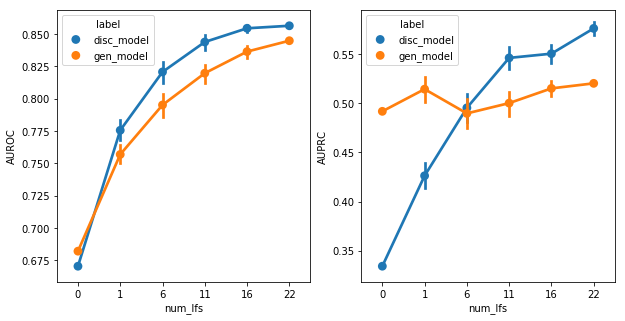

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=dev_performance_dict["CtD"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=dev_performance_dict["CtD"], ax=axs[1])

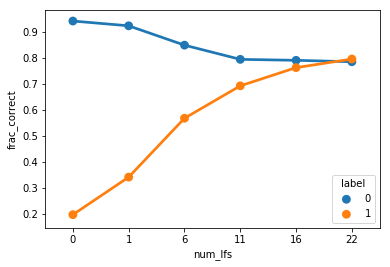

In [23]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=dev_class_performance_dict["CtD"])

## Test Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


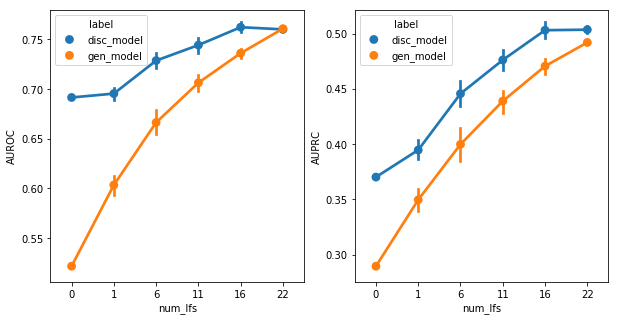

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=test_performance_dict["CtD"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=test_performance_dict["CtD"], ax=axs[1])

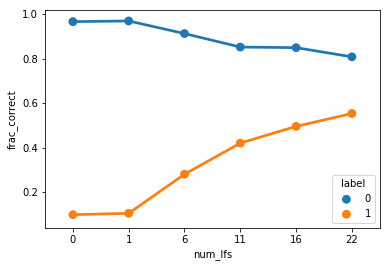

In [25]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=test_class_performance_dict["CtD"])

In [26]:
dev_performance_dict["CtD"].to_csv(
    "results/CtD/results/dev_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_performance_dict["CtD"].to_csv(
    "results/CtD/results/test_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [27]:
dev_class_performance_dict["CtD"].to_csv(
    "results/CtD/results/dev_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_class_performance_dict["CtD"].to_csv(
    "results/CtD/results/test_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# Disease Associates Gene Sources 

## Dev Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


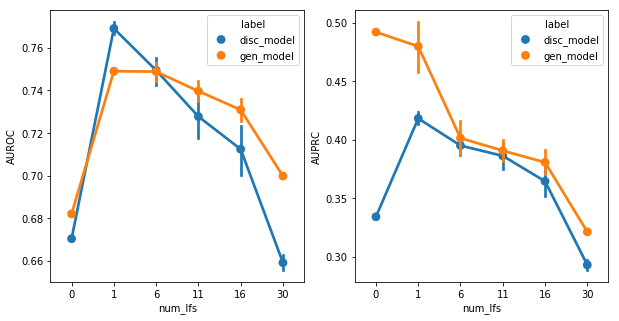

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=dev_performance_dict["DaG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=dev_performance_dict["DaG"], ax=axs[1])

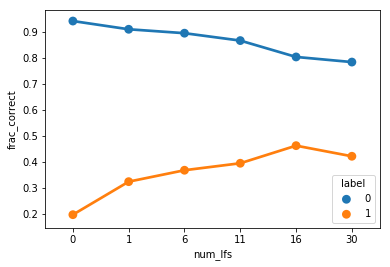

In [29]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=dev_class_performance_dict["DaG"])

## Test Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


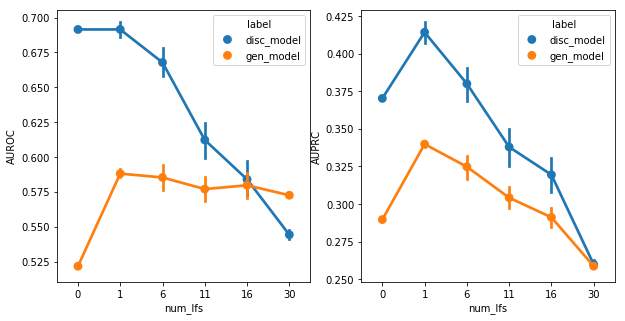

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=test_performance_dict["DaG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=test_performance_dict["DaG"], ax=axs[1])

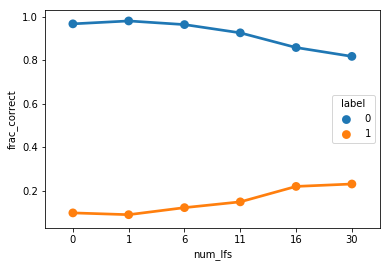

In [31]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=test_class_performance_dict["DaG"])

In [32]:
dev_performance_dict["DaG"].to_csv(
    "results/DaG/results/dev_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_performance_dict["DaG"].to_csv(
    "results/DaG/results/test_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [33]:
dev_class_performance_dict["DaG"].to_csv(
    "results/DaG/results/dev_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_class_performance_dict["DaG"].to_csv(
    "results/DaG/results/test_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# Compound Binds Gene Sources

## Dev Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


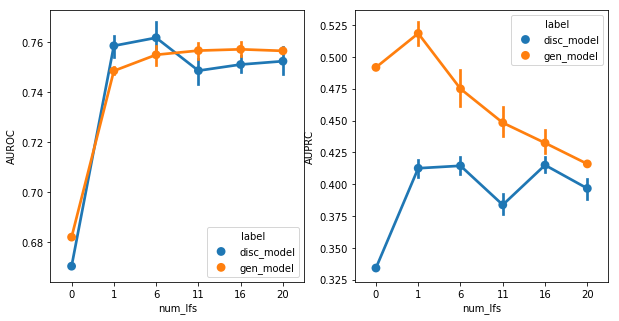

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=dev_performance_dict["CbG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=dev_performance_dict["CbG"], ax=axs[1])

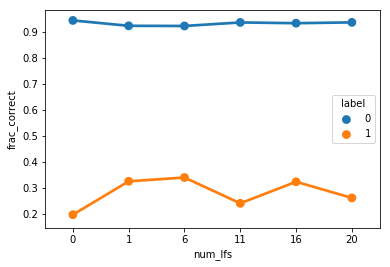

In [35]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=dev_class_performance_dict["CbG"])

## Test Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


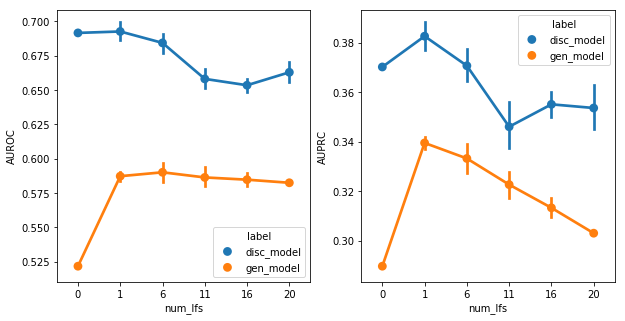

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=test_performance_dict["CbG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=test_performance_dict["CbG"], ax=axs[1])

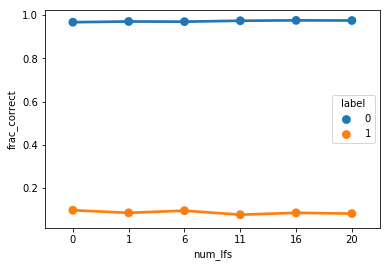

In [37]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=test_class_performance_dict["CbG"])

In [38]:
dev_performance_dict["CbG"].to_csv(
    "results/CbG/results/dev_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_performance_dict["CbG"].to_csv(
    "results/CbG/results/test_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [39]:
dev_class_performance_dict["CbG"].to_csv(
    "results/CbG/results/dev_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_class_performance_dict["CbG"].to_csv(
    "results/CbG/results/test_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# Gene interacts Gene Sources

## Dev Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


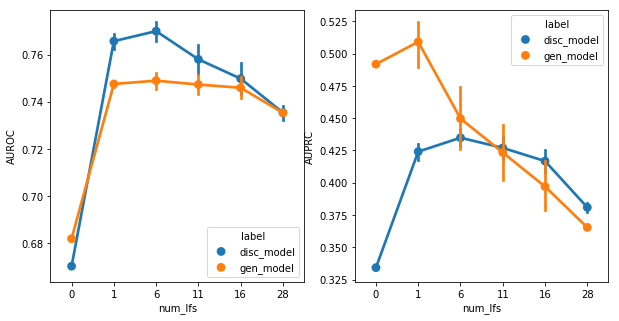

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=dev_performance_dict["GiG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=dev_performance_dict["GiG"], ax=axs[1])

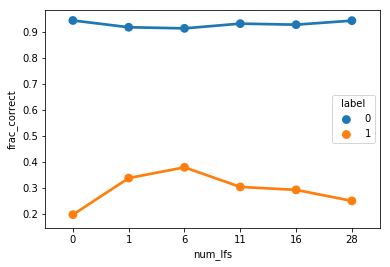

In [41]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=dev_class_performance_dict["GiG"])

## Test Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


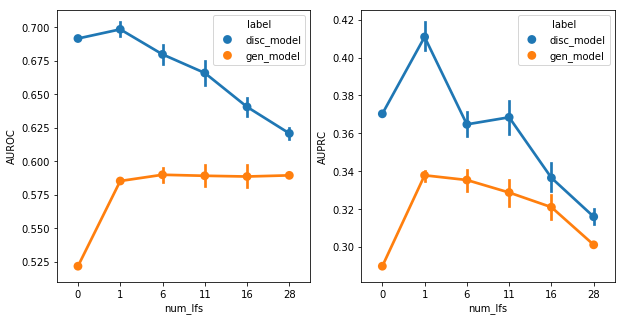

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=test_performance_dict["GiG"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=test_performance_dict["GiG"], ax=axs[1])

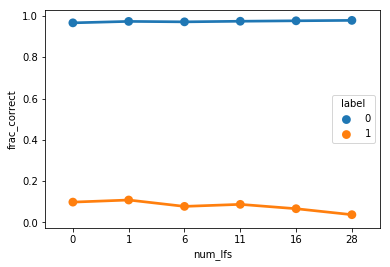

In [43]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=test_class_performance_dict["GiG"])

In [44]:
dev_performance_dict["GiG"].to_csv(
    "results/GiG/results/dev_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_performance_dict["GiG"].to_csv(
    "results/GiG/results/test_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [45]:
dev_class_performance_dict["GiG"].to_csv(
    "results/GiG/results/dev_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_class_performance_dict["GiG"].to_csv(
    "results/GiG/results/test_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# All

## Dev Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


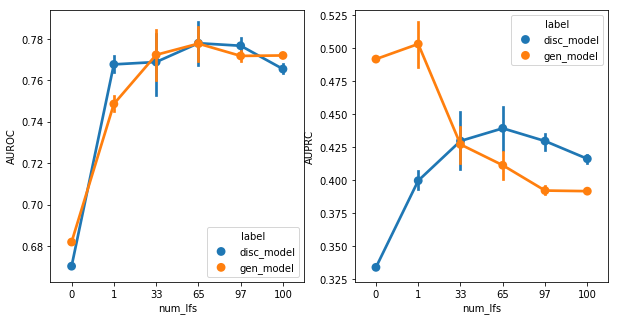

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=dev_performance_dict["All"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=dev_performance_dict["All"], ax=axs[1])

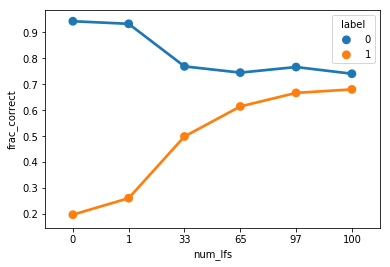

In [47]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=dev_class_performance_dict["All"])

## Test Set

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


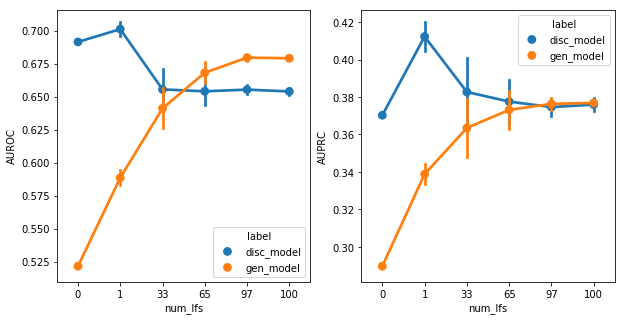

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUROC", hue="label", data=test_performance_dict["All"], ax=axs[0])
sns.pointplot(x="num_lfs", y="AUPRC", hue="label", data=test_performance_dict["All"], ax=axs[1])

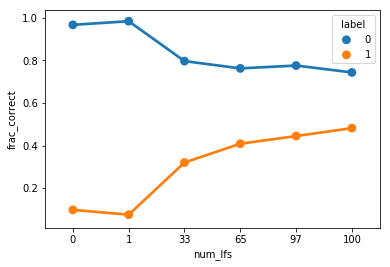

In [49]:
sns.pointplot(x="num_lfs", y="frac_correct", hue="label", data=test_class_performance_dict["All"])

In [50]:
dev_performance_dict["All"].to_csv(
    "results/all/results/dev_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_performance_dict["All"].to_csv(
    "results/all/results/test_disc_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [51]:
dev_class_performance_dict["GiG"].to_csv(
    "results/all/results/dev_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_class_performance_dict["GiG"].to_csv(
    "results/all/results/test_disc_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)